# Satellite Data for Trend Analysis of Lake Surface Water Temperature in Climate Change Monitoring

Production date: 12-Nov-2024

Produced by: Camila Trigoso (VUB)

## 🌍 Use case: Utilize satellite-derived lake surface water temperature data for climate change  monitoring

## ❓ Quality assessment question(s)
* **Can satellite data be used to detect the observed increase in summer water temperatures in Lake Superior due to global warming?**

Cases of an increasing trend in lake surface water temperature (LSWT) have been observed in numerous lakes across various regions, including the United States, Europe, and other parts of the world [1][2]. For example, Austin and Colman (2008) found that summer LSWT in Lake Superior increased at a rate of (11±6)×10^-2 °C/year from 1979 to 2006. They attributed this trend to the earlier retreat of winter ice, which causes the positive overturning period to begin sooner, allowing the lake more time to warm. Their analysis was based on measurements from in-situ buoys [3]. Later, the Great Lakes Integrated Sciences and Assessments (GLISA) analyzed the annual mean LSWT of Lake Superior between 1995 and 2021. The increasing long-term trend observed by Austin and Colman was not apparent in the period analyzed by GLISA. However, they noted a shift to higher temperatures after 1998 [4]. The LSWT data analyzed by GLISA was derived from satellite observations and obtained through the NOAA Great Lakes CoastWatch [5].

The objective of this study is to evaluate whether the [satellite-lake-water-temperature](https://cds.climate.copernicus.eu/datasets/satellite-lake-water-temperature?tab=overview) dataset from the Climate Data Store (CDS) is suitable for climate change monitoring, using Lake Superior as a case study. We calculated the trend summer LWST for a period of 28 years, from 1995 to 2023.

## 📢 Quality assessment statement
```{admonition} These are the key outcomes of this assessment
:class: note
* Lake Superior's summer LSWT trend from 1995 to 2023 shows a slightly negative slope, though this trend is not statistically significant. The mean summer temperature during this period was 14.1 °C.
* The satellite-lake-water-temperature dataset and NOAA’s satellite-derived LSWT data are closely aligned, showing very similar values. Thus, the pattern of our summer mean results resembles the yearly mean trends reported by GLISA.
* This dataset is valuable for climate change monitoring. However, complementing it with in situ data from years prior to 1995, if available, could provide a more comprehensive understanding of long-term trends.
```

## 📋 Methodology

The analysis and results are organized in the following steps, which are detailed in the sections below:

**[](section-1)**
 * Download satellite water temperature data for the summer months (July, August, September) from 1995 to 2023.

**[](section-2)**
 * Filter the data by quality level and lake ID.
 * Calculate the spatial weighted mean of LSWT.

**[](section-3)**
 * Calculate the yearly summer mean of LSWT.
 * Perform linear regression.
 * Plot the results.
 
**[](section-4)** 
 * Calculate the day of the year mean of LSWT.
 * Load the NOAA dataset with the average LSWT for day of the year for the period 1995 to 2023.
 * Plot the day of the year mean of LSWT for the CDS dataset and the NOAA dataset.
 * Observe the pattern of yearly LWST by GLISA in relation to the results from Section 3. 

## 📈 Analysis and results

(section-1)=
### 1. Request and download data

#### Import packages

In [74]:
import cartopy.crs as ccrs
import matplotlib.cbook
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from c3s_eqc_automatic_quality_control import diagnostics, download, plot, utils
from scipy.stats import linregress
from matplotlib.lines import Line2D
plt.style.use("seaborn-v0_8-notebook")

#### Set variables

In [75]:
# Time
year_start = 1995
year_stop = 2023

# Region
lon_slice = slice(-92.10, -84.80)
lat_slice = slice(46.30, 49.00)

# Variable
varname = "lake_surface_water_temperature"

#### Set the data request

In [76]:
collection_id = "satellite-lake-water-temperature"
requests = []
for year in range(year_start, year_stop + 1):
    requests.append(
        {
            "variable": "all",
            "year": [str(year)],
            "month": ["07", "08", "09"],
            "day": [f"{day:02d}" for day in range(1, 32)],
            "version": ["4_5" if year < 2021 else "4_5_2"],
        }
    )

#### Download data

In [77]:
ds = download.download_and_transform(
    collection_id,
    requests,
    transform_func=utils.regionalise,
    transform_func_kwargs={"lon_slice": lon_slice, "lat_slice": lat_slice},
    chunks={"year": 1},
)

100%|██████████| 29/29 [00:09<00:00,  3.13it/s]


(section-2)=
### 2. Data preprocessing 

#### Plot lakeid

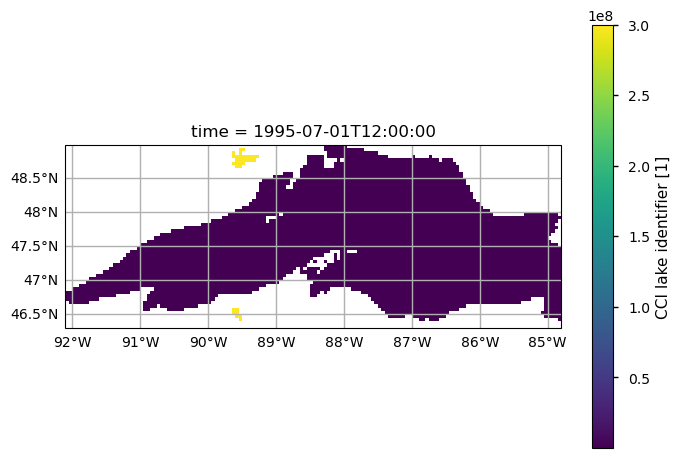

In [78]:
_ = plot.projected_map(
    ds["lakeid_CCI"].isel(time=0),
    projection=ccrs.PlateCarree(),
    show_stats=False,
)

##### Figure 1
Map to identify Lake Superior ID

In [80]:
print(np.unique(ds["lakeid_CCI"].values))

[2.00000000e+00 3.00000709e+08 3.00008645e+08            nan]


#### Data filtering

It can be observed that the lake ID of Lake Superior is 2, which is the lowest value when printing the values, and it is plotted in purple.
Regarding the quality level. We will only use these levels:
- 4: good quality
- 5: best quality

In [81]:
# Reindex using lakeids and min_quality_level
lakeid = (
    xr.DataArray(np.unique(ds["lakeid_CCI"].values), dims=("lakeid_CCI"))
    .dropna("lakeid_CCI")
    .astype(int)
)
min_quality_level = xr.DataArray([0, 4], dims=("min_quality_level"))
ds = ds.drop_vars("lakeid_CCI").where(ds["lakeid_CCI"] == lakeid)
ds = ds.where(ds["lswt_quality_level"] >= min_quality_level)
ds = ds.assign_coords(lakeid_CCI=lakeid, min_quality_level=min_quality_level)

filtered_ds = ds.sel(lakeid_CCI=2, min_quality_level=4)

#### Spatial weighted mean

In [82]:
# Spatial weighted mean
da = diagnostics.spatial_weighted_mean(filtered_ds[varname])

(section-3)=
### 3. Summer yearly mean analisys
#### Summer yearly mean and standard error of the mean (SEM)

In [83]:
#Convert to °C
daC = da - 273.15 #We convert to °C for comparison with Austin & Colman (2007)
#Calculate the mean
summer_yearly_mean = daC.groupby('time.year').mean(dim='time')
#Calculate the standard deviation
summer_yearly_std_dev = daC.groupby('time.year').std(dim='time')
#Calculate the SEM
summer_yearly_counts = daC.groupby('time.year').count(dim='time')
summer_yearly_sem  = summer_yearly_std_dev / np.sqrt(summer_yearly_counts)
#Calculate the 95% confidence interval
ci_lower = summer_yearly_mean - 1.96 * summer_yearly_sem
ci_upper = summer_yearly_mean + 1.96 *summer_yearly_sem

#### Perform linear regression for the full set (1995-2023)

In [85]:
# Define the years for the full dataset and subset
years_full = summer_yearly_mean['year'].values

# Perform linear regression on the full dataset
slope_full, intercept_full, r_value, p_value, std_err = linregress(years_full, summer_yearly_mean.values)
trend_full = slope_full * years_full + intercept_full

# Print the linear regression equation in a readable format
print(f"The equation of the trend line is: \ny = {slope_full:.4f} °C/year * x + {intercept_full:.4f} °C")
# Printing the results
print("\nSlope of the trend line:", round(slope_full,4),"°C/year")
print("Intercept of the trend line:", round(intercept_full,4),"°C")
print("Correlation coefficient (R value):", round(r_value,4))
print("P-value of the regression:", round(p_value,4))
print("Standard error of the slope:", round(std_err,4),"°C/year")


The equation of the trend line is: 
y = -0.0133 °C/year * x + 40.7965 °C

Slope of the trend line: -0.0133 °C/year
Intercept of the trend line: 40.7965 °C
Correlation coefficient (R value): -0.0887
P-value of the regression: 0.6472
Standard error of the slope: 0.0287 °C/year


#### Plot results

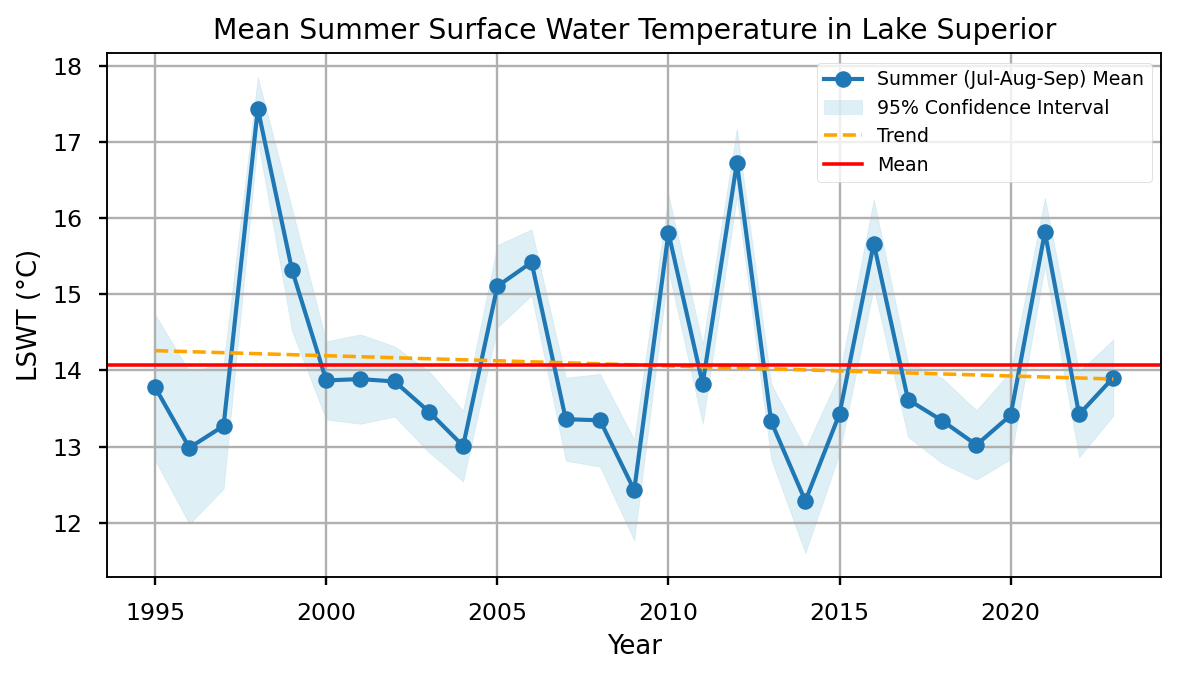

In [120]:
# Plot both the original data and the trend lines
plt.figure(figsize=(8,4), dpi=170)

#Plot yearly mean with 95% confidence interval
plt.plot(years_full, summer_yearly_mean, label="Summer (Jul-Aug-Sep) Mean", marker="o")
plt.fill_between(years_full, ci_lower, ci_upper, color="lightblue", alpha=0.4, label="95% Confidence Interval")

# Plot the trend lines
plt.plot(years_full, trend_full, label="Trend", color="orange",  linestyle="--", linewidth=1.5)
mean_all=summer_yearly_mean.mean(dim='year').values.item()
plt.axhline(y=mean_all, color='red', linestyle='-', label='Mean',linewidth=1.5)

# Add labels, title, and legend
plt.xlabel("Year")
plt.ylabel("LSWT (°C)")  # Adjust units if necessary
plt.title("Mean Summer Surface Water Temperature in Lake Superior")
plt.legend(fontsize=8) 
plt.grid(True)
plt.show()

##### Figure 2
Summer yearly mean from 1995 to 2023 using the CDS dataset.

#### Analysis
The trend line in Figure 2 has a negative slope of -0.0133 °C/yr. However, the standard error of the slope is 0.0287 °C/year, which is relatively large compared to the slope itself, indicating low confidence in this trend. Additionally, the p-value of 0.6472 is substantially higher than the commonly used significance threshold of 0.05. This high p-value suggests that the trend is not statistically significant. The absence of significance could be partly due to the relatively short period of 28 years analyzed in this study, as longer time series are often needed to detect meaningful climate trends in such large water bodies.

The findings from Austin and Colman (2008) [3] provide additional context to the LSWT trends in Lake Superior. Their analysis, which included in situ buoy measurements, showed an increasing trend in lake surface temperature during the 1980s and 1990s. This warming period may have led to elevated temperature levels that persisted in the following decades. Although the current analysis from 1995 to 2023 does not reveal a statistically significant trend, Austin and Colman's findings suggest that earlier warming could have established a higher baseline, potentially masking any recent, subtle changes in LSWT.


(section-4)=
### 4. Comparison to NOAA Great Lakes CoastWatch data

#### Day of the year mean

In [121]:
doy = daC.groupby("time.dayofyear")
mean_doy=doy.mean(dim="time")

#### Load the NOAA dataset

In [122]:
#NOAA data
df_noaa = pd.read_csv("/data/wp5/trigoso_camila/LakeSurfaceTemperature/avgtemps-s_1995-2024_C.csv") 
# Assuming your DataFrame is named 'df'
df_noaa_subset = df_noaa.iloc[182:275] 
#The range is the day of the year fro the 1st of July and 30th of September

The CSV file is titled "Long-term Average Surface Water Temperature Compared to 2024 (CSV, 1995-2023)" and is in °C. This file was obtained from the NOAA Great Lakes CoastWatch webpage [5].

The NOAA CoastWatch Great Lakes Regional Node dataset provides lake surface water temperature (LSWT) data derived from multiple sources, including the NOAA Advanced Very High Resolution Radiometer (AVHRR), the Visible Infrared Imaging Radiometer Suite on the Suomi National Polar-Orbiting Partnership spacecraft (VIIRS S-NPP), and the VIIRS instrument on NOAA-20 [6]. 

#### Plot

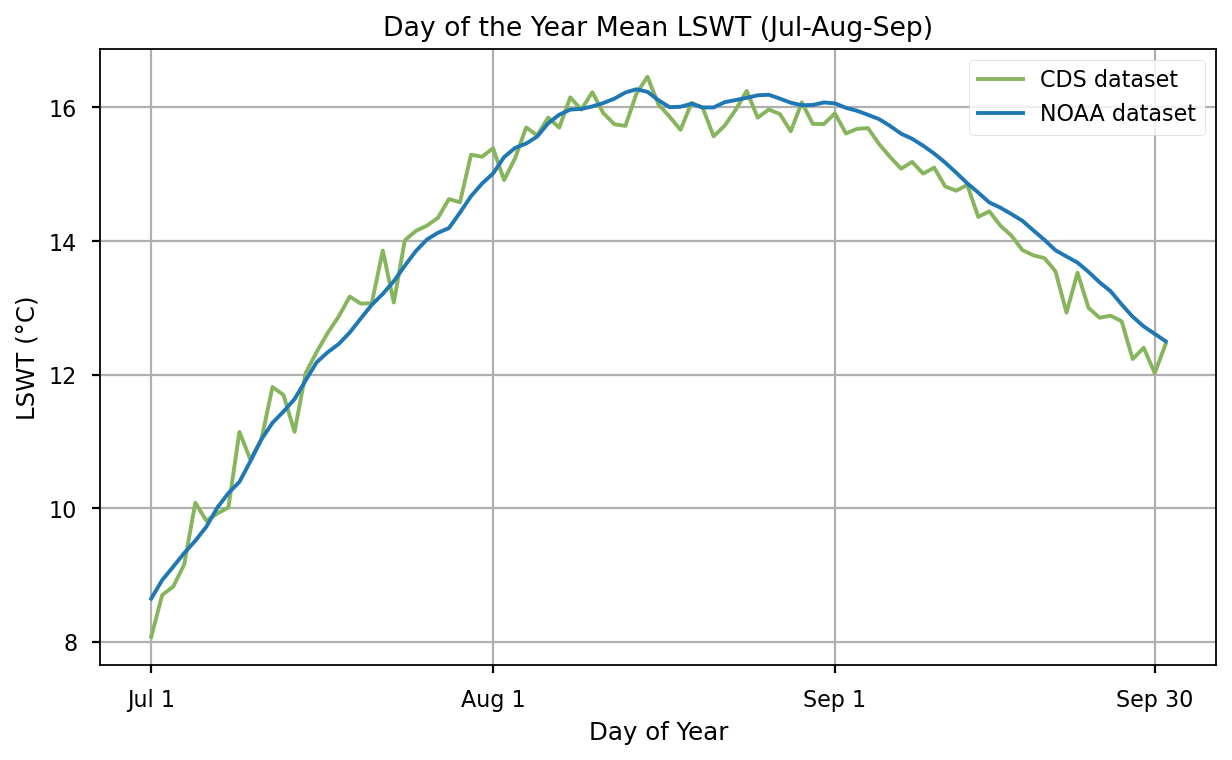

In [123]:
# Create the plot
plt.figure(figsize=(9, 5),dpi=160)

# Plot interval 1 mean (1995-2004) with label and color
mean_doy.plot(label='CDS dataset', color='#87B55D')

plt.plot(df_noaa_subset.index, df_noaa_subset["Average (1995-2023)"], label='NOAA dataset')

# Set x-ticks to represent the days from July 1 to September 30
plt.xticks([182, 213, 244, 273], ['Jul 1', 'Aug 1', 'Sep 1', 'Sep 30'])
# Add title and labels
plt.title("Day of the Year Mean LSWT (Jul-Aug-Sep)")
plt.xlabel("Day of Year")
plt.ylabel("LSWT (°C)")

plt.grid(True)
# Show legend
plt.legend()

# Display the plot
plt.show()

##### Figure 3
Day of the year mean for the period 1995 to 2023 comparing the CDS dataset and the NOAA dataset.

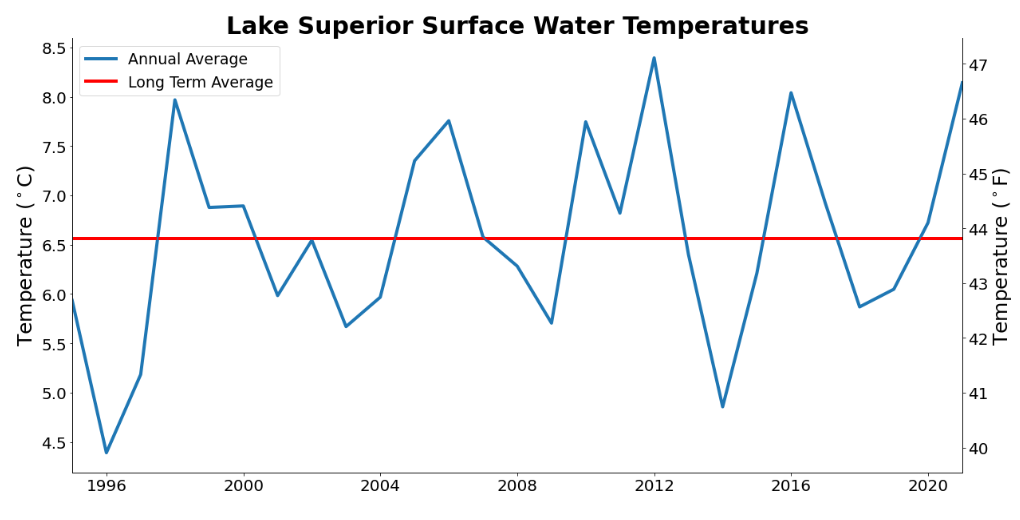
##### Figure 4
Annual (blue) and long term average (red) Lake Superior surface water temperatures from 1995 through 2021. Source: GLISA (2024)[4]

#### Analysis
The shape of the summer yearly mean LSWT calculated in this analysis closely resembles the pattern observed in GLISA’s yearly mean from 1995 to 2021 (Figure 4), though the absolute values differ due to the seasonal focus. Additionally, plotting NOAA’s summer LSWT data against the CDS data (Figure 3) shows strong alignment, with both datasets reflecting very similar values for the summer months. This similarity in patterns supports the reliability of the CDS dataset for monitoring seasonal trends.

## ℹ️ If you want to know more

### Key resources

Dataset documentation:
* [LSWT v4.5: Product User Guide and Specification (PUGS)](https://confluence.ecmwf.int/pages/viewpage.action?pageId=348800177)

Code libraries used:
* [C3S EQC custom functions](https://github.com/bopen/c3s-eqc-automatic-quality-control/tree/main/c3s_eqc_automatic_quality_control), `c3s_eqc_automatic_quality_control`, prepared by [BOpen](https://www.bopen.eu/)

### References

List the references used in the Notebook here.


* [[1]](https://doi.org/10.1038/s41558-024-02122-y) Wang, X., Shi, K., Qin, B. et al. (2024). Disproportionate impact of atmospheric heat events on lake surface water temperature increases. Nat. Clim. Chang.
* [[2]](https://climate.copernicus.eu/lake-surface-temperatures) Copernicus (2018). Lake surface temperatures. Climate Change Service.
* [[3]](https://doi.org/10.1029/2006GL029021) Jay A. Austin, Steven M. Colman (2007). Lake Superior summer water temperatures are increasing more rapidly than regional air temperatures: A positive ice-albedo feedback. Geophysical Research LettersVolume 34, Issue 6. 
* [[4]](https://glisa.umich.edu/lake-superior-retrospective/) GLISA (2024). Lake Superior Retrospective.
* [[5]](https://coastwatch.glerl.noaa.gov/statistics/average-surface-water-temperature-glsea/) NOAA CoastWatch Great Lakes Regional Node (2024). Average Surface Water Temperature (GLSEA).